In [1]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm
%matplotlib inline
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [2]:
# Ref: https://github.com/GiggleLiu/QuantumCircuitBornMachine/blob/master/qcbm/dataset.py
def unpacknbits(arr, nbit, axis=-1):
    '''unpack numbers to bits.'''
    nd = np.ndim(arr)
    if axis < 0:
        axis = nd + axis
    return (((arr & (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1)))) > 0).astype('int8')


def packnbits(arr, axis=-1):
    '''pack bits to numbers.'''
    nd = np.ndim(arr)
    nbit = np.shape(arr)[axis]
    if axis < 0:
        axis = nd + axis
    return (arr * (1 << np.arange(nbit - 1, -1, -1)).reshape([-1] + [1] * (nd - axis - 1))).sum(axis=axis, keepdims=True).astype('int')

def digit_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return x

def binary_basis(geometry):
    num_bit = np.prod(geometry)
    M = 2**num_bit
    x = np.arange(M)
    return unpacknbits(x[:,None], num_bit).reshape((-1,)+geometry)

def gaussian_pdf(geometry, mu, sigma):
    '''get gaussian distribution function'''
    x = digit_basis(geometry)
    pl = 1. / np.sqrt(2 * np.pi * sigma**2) * \
        np.exp(-(x - mu)**2 / (2. * sigma**2))
    return pl/pl.sum()

def barstripe_pdf(geometry):
    '''get bar and stripes PDF'''
    x = binary_basis(geometry)
    pl = is_bs(x)
    return pl/pl.sum()

def is_bs(samples):
    '''a sample is a bar or a stripe.'''
    return (np.abs(np.diff(samples,axis=-1)).sum(axis=(1,2))==0)|((np.abs(np.diff(samples, axis=1)).sum(axis=(1,2)))==0)

/home/hmzhao/.conda/envs/ode-rnn/lib/python3.9/site-packages/matplotlib/text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


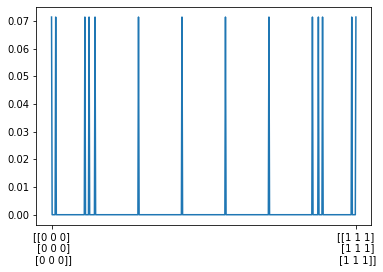

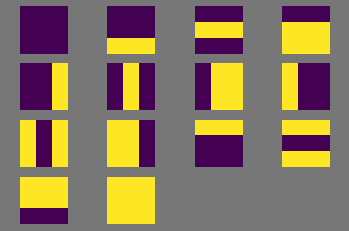

In [3]:
geometry = (3,3)
pl2 = barstripe_pdf(geometry)
plt.plot(pl2)

# show ticks
basis = binary_basis(geometry)
plt.xticks([0, 511], [basis[0], basis[511]])
plt.show()

# generate samples
samples = basis[pl2>1e-2]

# show bar and stripes
def plot_bs(samples, size):
    plt.figure(facecolor='#777777')
    gs = plt.GridSpec(*size)

    for i in range(size[0]):
        for j in range(size[1]):
            if i*size[1]+j == len(samples): break
            plt.subplot(gs[i,j]).imshow(samples[i*size[1]+j], vmin=0, vmax=1)
            plt.axis('equal')
            plt.axis('off')
    plt.show()

size = (4, 4)
plot_bs(samples, size)

In [5]:
n = 9 # n qubits
n_layers = n ** 2 # number of layers in variational circuit
if n == 1:
    n_layers = 0
dev = qml.device('default.qubit', wires=n)

In [10]:
def get_target(sample_pos):
    '''
        Prepare target state at the first n qubits.
    '''
    state = np.zeros(2**n)
    state[sample_pos] = 1
    qml.QubitStateVector(state, wires=list(range(n)))

In [11]:
def variational_circuit(n_layers, weights, wires, **kwargs):
    '''
        Template for a variational circuit.
    '''
    pos = 0
    for i in range(len(wires)):
        qml.RX(weights[pos], wires=wires[i])
        qml.RY(weights[pos+1], wires=wires[i])
        qml.RZ(weights[pos+2], wires=wires[i])
        pos += 3

    for layer in range(n_layers):
        for i in range(len(wires)-1):
            qml.CNOT(wires=[wires[i], wires[i+1]])
        qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
        
        for i in range(len(wires)):
            qml.RX(weights[pos], wires=wires[i])
            qml.RY(weights[pos+1], wires=wires[i])
            qml.RZ(weights[pos+2], wires=wires[i])
            pos += 3

In [12]:
def variational_qpca(n_layers, variational_params, **kwargs):
    '''
        Perform variational quantum PCA.
    '''
    variational_circuit(n_layers, variational_params, np.arange(n))

In [39]:
@qml.qnode(dev, interface="tf")
def measurement(sample_pos, n_layers, variational_params, **kwargs):
    '''
        Measure sigma_z for computing PCA loss.
    '''
    get_target(sample_pos)
    variational_qpca(n_layers, variational_params)
    z = []
    for i in range(n):
        z.append(qml.expval(qml.PauliZ(i)))
    return z

def loss_qpca(sample_pos, n_layers, variational_params, **kwargs):
    '''
        Compute loss for variational quantum PCA, i.e. $Tr(U \rho U^dagger P)$.
    '''
    z = measurement(sample_pos, n_layers, variational_params)
    return 1 / 2 ** n / (2 ** n - 1) * tf.math.reduce_sum((z + 1) * (2 ** tf.range(n, dtype=tf.double)))

In [40]:
# initialize parameters
np.random.seed(0)
tf.random.set_seed(0)
# n_target_params = (n_layers + 1) * 3 * m
n_var_params = (n_layers + 1) * 3 * n

# target_params = np.array([0] * n_target_params) + np.random.normal(scale=np.pi, size=(n_target_params,))

eps = 1e-2
init_var_params = np.array([0] * n_var_params) + np.random.normal(scale=eps, size=(n_var_params,))
# init_var_params = np.loadtxt('./ckpt.csv', delimiter=',')
var_params = tf.Variable(init_var_params)

# SGD faces barren plateau, Adam is better
# lr = 6 for SGD, 0.1 for Adam
# opt = tf.keras.optimizers.SGD(6)
opt = tf.keras.optimizers.Adam(0.1, decay=0.1)
# opt = tf.keras.optimizers.Adadelta(lr=0.1)

In [41]:
# sigular value decomposition
target_state = np.diag(pl2)
U, S, V = np.linalg.svd(target_state)
print('eigenvalues: ', S[:20])

# calculate theoretical minimum of loss
loss_minimum = np.sum(S * np.arange(len(S))) / 2 ** n / (2 ** n - 1) * 2
loss_maximum = np.sum(S * np.arange(len(S))[::-1]) / 2 ** n / (2 ** n - 1) * 2
print('loss minimum: ', loss_minimum)
print('loss maximum: ', loss_maximum)

eigenvalues:  [7.14285714e-02 7.14285714e-02 7.14285714e-02 7.14285714e-02
 7.14285714e-02 7.14285714e-02 7.14285714e-02 7.14285714e-02
 7.14285714e-02 7.14285714e-02 7.14285714e-02 7.14285714e-02
 7.14285714e-02 7.14285714e-02 7.13714802e-18 7.13714802e-18
 7.13714802e-18 7.13714802e-18 7.13714802e-18 7.13714802e-18]
loss minimum:  4.968811154599539e-05
loss maximum:  0.0038565618884540153


In [42]:
def get_sample(prob):
    return np.random.choice(np.arange(0, 2**n), p=prob)

In [44]:
# train variational quantum PCA
n_step = 200
n_batch = 5

def cost():
    c = 0
    for b in range(n_batch):
        sample_pos = get_sample(pl2)
        c += loss_qpca(sample_pos, n_layers, var_params) / n_batch
    return c

cost_list = []
for step in tqdm(range(n_step)):
    opt.minimize(cost, var_params)
    cost_val = cost().numpy()
    cost_list.append(cost_val)
    if step % 5 == 0:
        tqdm.write("Step {}: cost = {}, relative excess = {}".format(step, cost_val, (cost_val - loss_minimum) / (loss_minimum)))
        np.savetxt('./ckptBAS.csv', var_params.numpy(), delimiter=',')

  0%|          | 0/200 [00:00<?, ?it/s]

KeyboardInterrupt: 